In [1]:
import os
import pandas as pd
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.io import read_image
from torchvision import transforms
from torch import nn
import matplotlib.pyplot as plt
import torch
import numpy as np

# Dataset

In [ ]:
from torchvision import datasets

training_data = datasets.FashionMNIST(
    root="pasta",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

In [2]:
class Speleothem(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_dir + f"classify_{self.img_labels.iloc[idx, 2]}/{self.img_labels.iloc[idx, 0]}.png"
        image = read_image(img_path)
        image = image.float()
        resize = transforms.Resize((256, 256))
        image = resize(image)

        label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
speleothem = Speleothem("../image/dbe/database.csv", "../image/dbe/")

In [5]:
train_size = int(0.8 * len(speleothem))
test_size = len(speleothem) - train_size
train_dataset, test_dataset = random_split(speleothem, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

tensor(13.5000, dtype=torch.float64)


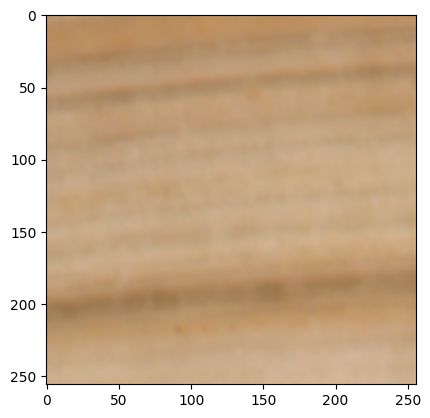

In [8]:
train_features, train_labels = next(iter(train_dataloader))
plt.imshow(train_features[0].int().permute(1, 2, 0))
print(train_labels[0])

# Model

In [43]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(256*256*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            torch.nn.Dropout(0.4),
            nn.Linear(512, 1)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [44]:
# device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

Using cpu device


In [45]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=196608, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.4, inplace=False)
    (5): Linear(in_features=512, out_features=1, bias=True)
  )
)


# Train

In [46]:
# loss_fn = nn.CrossEntropyLoss()
loss_fn = torch.nn.SmoothL1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [47]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y.view(-1,1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [48]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    correct_1 = 0
    correct_minus_1 = 0
    accuracies = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.view(-1,1)).item()
            accuracies+= 1 - np.abs((pred.detach().cpu().numpy().flatten() - y.detach().cpu().numpy().flatten())).mean().item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            # correct_1 += (pred.argmax(1) == y + 1).type(torch.float).sum().item()
            # correct_minus_1 += (pred.argmax(1) == y - 1).type(torch.float).sum().item()

    # test_loss /= num_batches
    # correct_1 = (correct + correct_1 + correct_minus_1) / size
    # correct /= size
    
    print(f"Test Error: \n Accuracy: {(100*accuracies):>0.1f}% and +/- 1 {(100*correct_1):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [49]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 34.057968  [    0/  146]
Test Error: 
 Accuracy: nan% and +/- 1 0.0%, Avg loss:      nan 

Epoch 2
-------------------------------
loss:     nan  [    0/  146]
Test Error: 
 Accuracy: nan% and +/- 1 0.0%, Avg loss:      nan 

Epoch 3
-------------------------------
loss:     nan  [    0/  146]
Test Error: 
 Accuracy: nan% and +/- 1 0.0%, Avg loss:      nan 

Epoch 4
-------------------------------
loss:     nan  [    0/  146]
Test Error: 
 Accuracy: nan% and +/- 1 0.0%, Avg loss:      nan 

Epoch 5
-------------------------------
loss:     nan  [    0/  146]
Test Error: 
 Accuracy: nan% and +/- 1 0.0%, Avg loss:      nan 

Epoch 6
-------------------------------
loss:     nan  [    0/  146]
Test Error: 
 Accuracy: nan% and +/- 1 0.0%, Avg loss:      nan 

Epoch 7
-------------------------------
loss:     nan  [    0/  146]
Test Error: 
 Accuracy: nan% and +/- 1 0.0%, Avg loss:      nan 

Epoch 8
-------------------------------
loss:     nan

In [50]:
train_features, train_labels = next(iter(train_dataloader))

In [51]:
model.eval()
x, y = train_features[2:3, :, :, :], train_labels[2]

with torch.no_grad():
    pred = model(x)
    predicted, actual = (pred.argmax(1) == y).type(torch.float).sum().item(), y
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "0.0", Actual: "16"


In [52]:
loss_fn(pred, y.view(-1,1))

tensor(nan)

In [53]:
import numpy as np
1 - np.abs((pred.detach().cpu().numpy().flatten() - y.detach().cpu().numpy().flatten())).mean().item()

nan

In [54]:
1-np.abs((result.detach().cpu().numpy().flatten() - label.detach().cpu().numpy().flatten())).mean().item()

NameError: name 'result' is not defined